In [1]:
import numpy
import py_entropy
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot

pyplot.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})

In [2]:
def make_mixed_experiments(n_layers=100, trials=16, num_mixed=16, num_experiments_per_trial=32, L=10, M=5):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)

    unit = numpy.array([1.0 + 0.0j])

    purities = []
    for _ in range(trials):
        choices = numpy.random.choice(numpy.arange(len(states)), replace=False, size=(num_mixed))
        chosen_states = states[choices]
        pure_states = [py_entropy.MultidefectPureState(chosen_states[[i],:], unit) for i in range(num_mixed)]
        state = py_entropy.MultiDefectState.new_mixed_from_states(states=[(1.0/num_mixed, state) for state in pure_states], 
                                                                  n_sites=L,
                                                                  num_experiments=num_experiments_per_trial,
                                                                  skip_float_checks=True)
        purity = state.apply_alternative_layers_and_save_mean_purity(n_layers)
        purities.append(purity)
    return numpy.array(purities)

In [3]:
L = 10
M = 4
states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)
hilbert_d = len(states)
hilbert_d

210

In [4]:
true_purities = []
purities = []

for num_mixed in [hilbert_d // i for i in 2**numpy.arange(1, 1+int(numpy.floor(numpy.log2(hilbert_d))))][::-1]:
    print(f"Mixing {num_mixed}")
    purities.append(make_mixed_experiments(n_layers=1000, num_mixed=num_mixed, L=L, M=M, num_experiments_per_trial=32))
    true_purities.append(1/num_mixed)
purities = numpy.array(purities)

Mixing 1
Mixing 3
Mixing 6
Mixing 13
Mixing 26
Mixing 52
Mixing 105


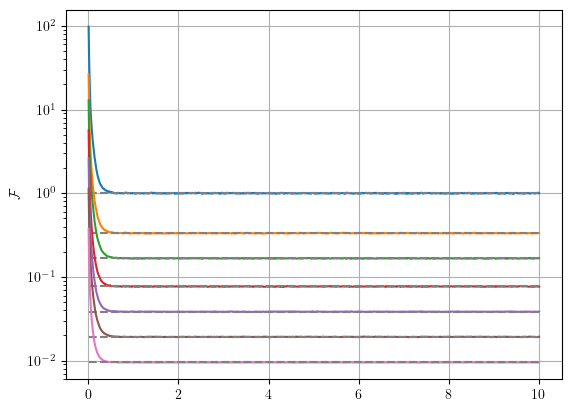

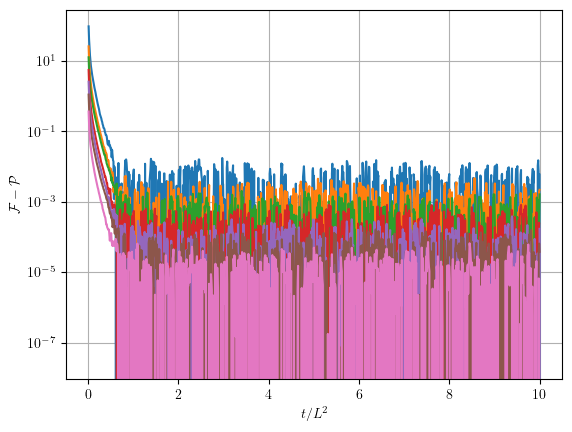

In [5]:
for tp, p in zip(true_purities, purities.mean(axis=1)):
    plot_def = pyplot.plot(numpy.arange(1, len(p)+1) / L**2, p)
    pyplot.plot([1/L**2,(len(p)+1)/L**2] , [tp,tp], '--', c='gray') # c=plot_def[0].get_color())
pyplot.yscale('log')
pyplot.ylabel('$\mathcal{F}$')
pyplot.grid()
pyplot.show()

for tp, p in zip(true_purities, purities.mean(axis=1)):
    pyplot.plot(numpy.arange(1, len(p)+1) / L**2, p - tp)
pyplot.yscale('log')
pyplot.ylabel('$\mathcal{F} - \mathcal{P}$')
pyplot.xlabel('$t/L^2$')
pyplot.grid()
pyplot.show()

In [3]:
def run_for(L=10,M=5,layers=1000,experiments=16,trials=16,max_mixture=None):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, M)
    hilbert_d = len(states)
    
    true_purities = []
    purities = []
    
    # for num_mixed in [hilbert_d // i for i in 2**numpy.arange(1, 1+int(numpy.floor(numpy.log2(hilbert_d))))][::-1]:
    for num_mixed in 2**numpy.arange(0, 1+int(numpy.floor(numpy.log2(hilbert_d)))):
        if max_mixture is not None:
            if max_mixture < num_mixed:
                break
        print(f"L={L} and M={M}: Mixing {num_mixed} of {hilbert_d}")
        purities.append(make_mixed_experiments(n_layers=layers, trials=trials, num_mixed=num_mixed, L=L, M=M, num_experiments_per_trial=experiments))
        true_purities.append(1/num_mixed)
    return numpy.array(purities), numpy.array(true_purities)

In [7]:
all_purities_half = []
all_true_purities_half = []
Ls_half = numpy.arange(4,12,2)
for L in Ls_half:
    M = L//2
    purities, true_purities = run_for(L=L,M=M,experiments=16,trials=16, max_mixture=128)
    all_purities_half.append(purities)
    all_true_purities_half.append(true_purities)

L=4 and M=2: Mixing 1 of 6
L=4 and M=2: Mixing 2 of 6
L=4 and M=2: Mixing 4 of 6
L=6 and M=3: Mixing 1 of 20
L=6 and M=3: Mixing 2 of 20
L=6 and M=3: Mixing 4 of 20
L=6 and M=3: Mixing 8 of 20
L=6 and M=3: Mixing 16 of 20
L=8 and M=4: Mixing 1 of 70
L=8 and M=4: Mixing 2 of 70
L=8 and M=4: Mixing 4 of 70
L=8 and M=4: Mixing 8 of 70
L=8 and M=4: Mixing 16 of 70
L=8 and M=4: Mixing 32 of 70
L=8 and M=4: Mixing 64 of 70
L=10 and M=5: Mixing 1 of 252
L=10 and M=5: Mixing 2 of 252
L=10 and M=5: Mixing 4 of 252
L=10 and M=5: Mixing 8 of 252
L=10 and M=5: Mixing 16 of 252
L=10 and M=5: Mixing 32 of 252
L=10 and M=5: Mixing 64 of 252
L=10 and M=5: Mixing 128 of 252


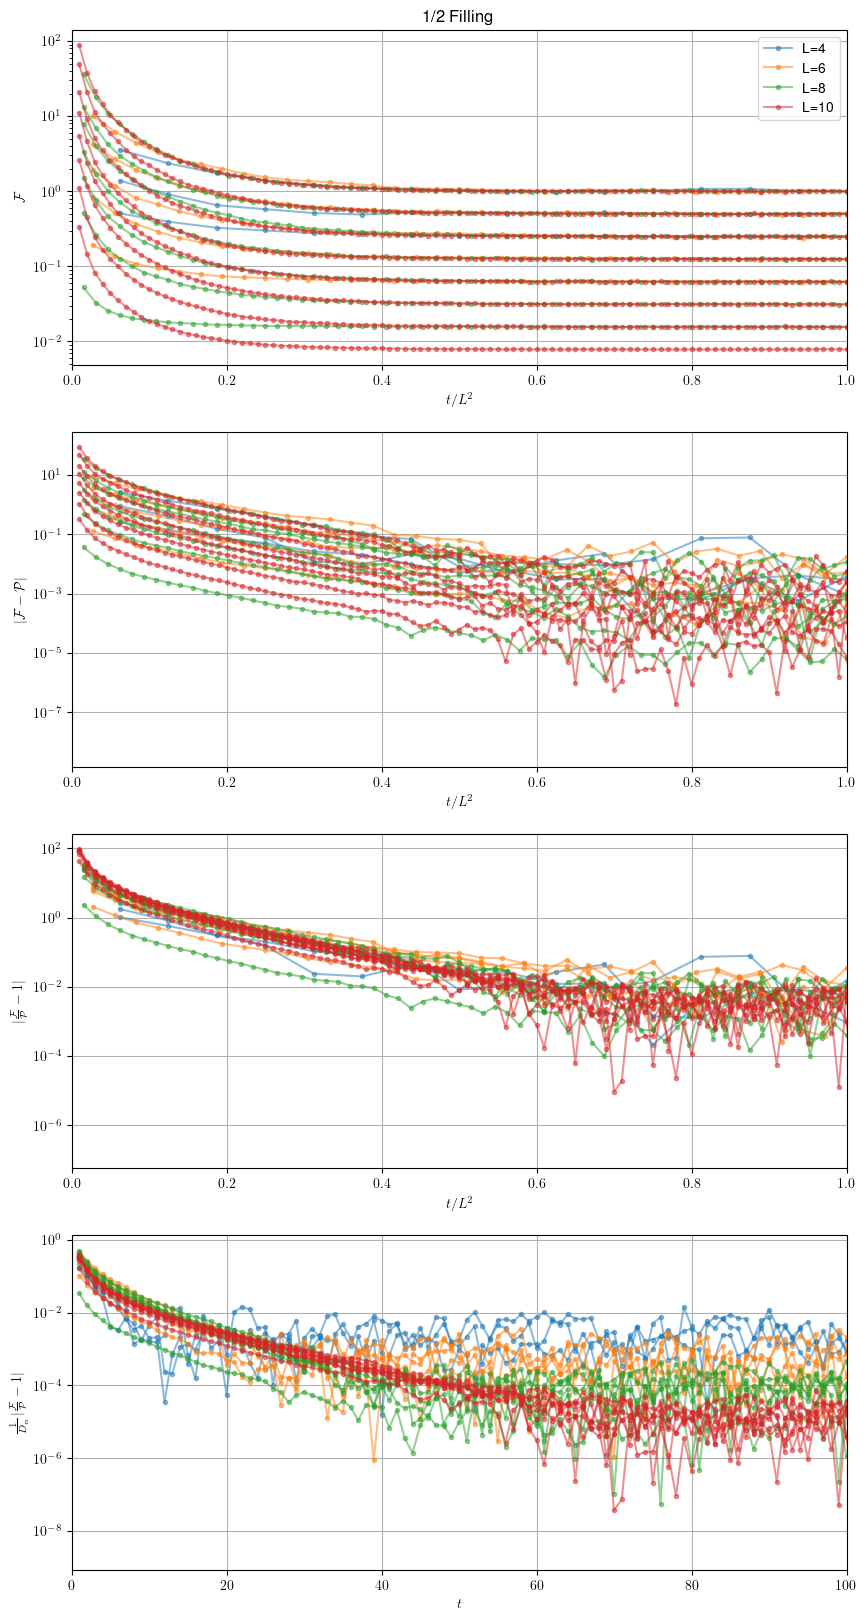

In [15]:
fig, axs = pyplot.subplots(4, figsize=(10, 20))

for L, purities, true_purities in zip(Ls_half, all_purities_half, all_true_purities_half):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, L//2)
    hilbert_d = len(states)

    color = None
    label = f"L={L}"
    for mixed_p, tp in zip(purities, true_purities):
        p = mixed_p.mean(axis=0)
        plot = axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p, '.-', c=color, alpha=0.5, label=label)
        label = None
        color = plot[0].get_color()
        axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp), '.-', c=color, alpha=0.5)
        axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/(tp), '.-', c=color, alpha=0.5)
        axs[3].plot(numpy.arange(1, len(p)+1), abs(p - tp)/(tp * hilbert_d), '.-', c=color, alpha=0.5)

axs[0].legend()

# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,1.0))
axs[0].grid()
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,1.0))
axs[1].grid()
# axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim((0,1.0))
axs[2].grid()
# axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlim((0,100))
axs[3].grid()

axs[0].set_ylabel(r'$\mathcal{F}$')
axs[0].set_xlabel(r'$t/L^2$')
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')
axs[1].set_xlabel(r'$t/L^2$')
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
axs[2].set_xlabel(r'$t/L^2$')
axs[3].set_ylabel(r'$\frac{1}{D_n}|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
axs[3].set_xlabel(r'$t$')

axs[0].set_title("1/2 Filling")
pyplot.show()

In [9]:
all_purities_third = []
all_true_purities_third = []
Ls_third = numpy.arange(3,15,3)
for L in Ls_third:
    M = L//3
    purities, true_purities = run_for(L=L,M=M,experiments=16,trials=16, max_mixture=128)
    all_purities_third.append(purities)
    all_true_purities_third.append(true_purities)

L=3 and M=1: Mixing 1 of 3
L=3 and M=1: Mixing 2 of 3
L=6 and M=2: Mixing 1 of 15
L=6 and M=2: Mixing 2 of 15
L=6 and M=2: Mixing 4 of 15
L=6 and M=2: Mixing 8 of 15
L=9 and M=3: Mixing 1 of 84
L=9 and M=3: Mixing 2 of 84
L=9 and M=3: Mixing 4 of 84
L=9 and M=3: Mixing 8 of 84
L=9 and M=3: Mixing 16 of 84
L=9 and M=3: Mixing 32 of 84
L=9 and M=3: Mixing 64 of 84
L=12 and M=4: Mixing 1 of 495
L=12 and M=4: Mixing 2 of 495
L=12 and M=4: Mixing 4 of 495
L=12 and M=4: Mixing 8 of 495
L=12 and M=4: Mixing 16 of 495
L=12 and M=4: Mixing 32 of 495
L=12 and M=4: Mixing 64 of 495
L=12 and M=4: Mixing 128 of 495


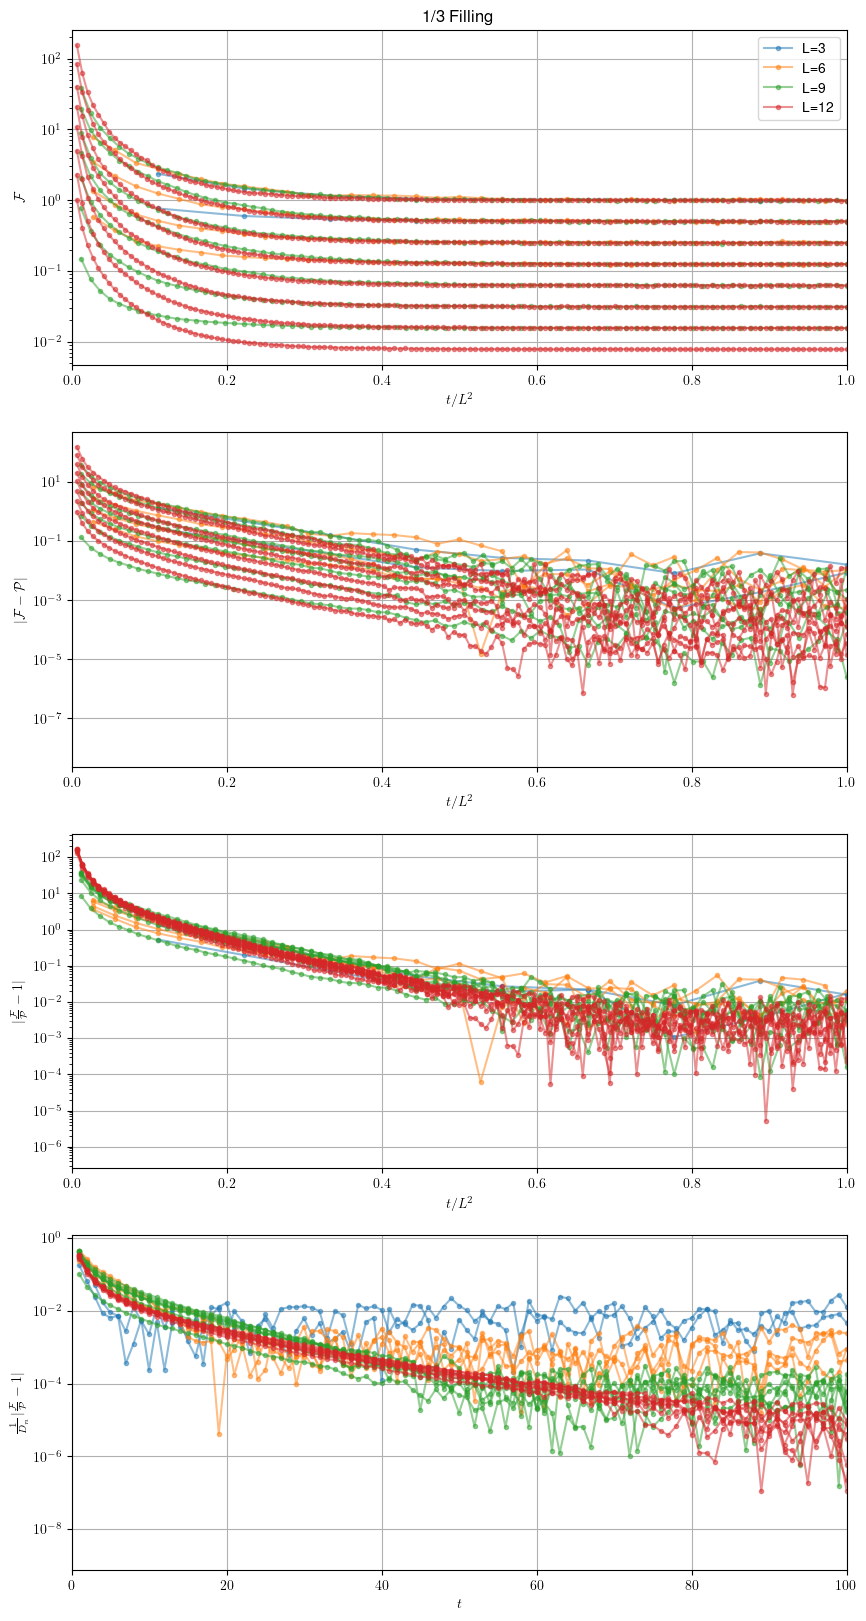

In [17]:
fig, axs = pyplot.subplots(4, figsize=(10, 20))

for L, purities, true_purities in zip(Ls_third, all_purities_third, all_true_purities_third):
    states = py_entropy.MultiDefectState.gen_enumerated_states(L, L//3)
    hilbert_d = len(states)

    color = None
    label = f"L={L}"
    for mixed_p, tp in zip(purities, true_purities):
        p = mixed_p.mean(axis=0)
        plot = axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p, '.-', c=color, alpha=0.5, label=label)
        color = plot[0].get_color()
        label = None
        axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp), '.-', c=color, alpha=0.5)
        axs[2].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp)/(tp), '.-', c=color, alpha=0.5)
        axs[3].plot(numpy.arange(1, len(p)+1), abs(p - tp)/(tp * hilbert_d), '.-', c=color, alpha=0.5)

axs[0].legend()

# axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlim((0,1.0))
axs[0].grid()
# axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlim((0,1.0))
axs[1].grid()
# axs[2].set_xscale('log')
axs[2].set_yscale('log')
axs[2].set_xlim((0,1.0))
axs[2].grid()
# axs[3].set_xscale('log')
axs[3].set_yscale('log')
axs[3].set_xlim((0,100))
axs[3].grid()

axs[0].set_ylabel(r'$\mathcal{F}$')
axs[0].set_xlabel(r'$t/L^2$')
axs[1].set_ylabel(r'$|\mathcal{F} - \mathcal{P}|$')
axs[1].set_xlabel(r'$t/L^2$')
axs[2].set_ylabel(r'$|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
axs[2].set_xlabel(r'$t/L^2$')
axs[3].set_ylabel(r'$\frac{1}{D_n}|\frac{\mathcal{F}}{\mathcal{P}} - 1|$')
axs[3].set_xlabel(r'$t$')

axs[0].set_title("1/3 Filling")
pyplot.show()

# Dimer compare

In [24]:
ne = 128
n_layers = 10000

all_purities = []

ls = 10*numpy.arange(1,11)
for l in tqdm(ls):
    state = numpy.array([1/numpy.sqrt(2)] + [0]*(l-2) + [1/numpy.sqrt(2)], dtype=numpy.complex128)
    part_on_bound = py_entropy.SingleDefectState(state, num_experiments=ne)
    purities = part_on_bound.apply_alternative_layers_and_save_mean_purity(n_layers)
    all_purities.append(purities)
pure_both_purities = numpy.array(all_purities)
    
print(f"Purity shape: {pure_both_purities.shape}")

all_purities = []

ls = 10*numpy.arange(1,11)


for l in tqdm(ls):
    all_states = []

    x = [0]*l
    x[0] = 1
    all_states.append(numpy.asarray(x, dtype=numpy.complex128))

    x = [0]*l
    x[-1] = 1
    all_states.append(numpy.asarray(x, dtype=numpy.complex128))

    part_on_bound = py_entropy.SingleDefectState.new_mixed([(0.5, s) for s in all_states], num_experiments=ne)
    purities = part_on_bound.apply_alternative_layers_and_save_mean_purity(n_layers)
    all_purities.append(purities)
mixed_purities = numpy.array(all_purities)

  0%|          | 0/10 [00:00<?, ?it/s]

Purity shape: (10, 10000)


  0%|          | 0/10 [00:00<?, ?it/s]

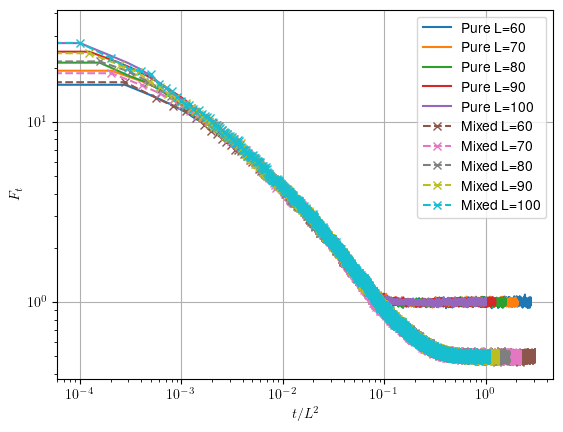

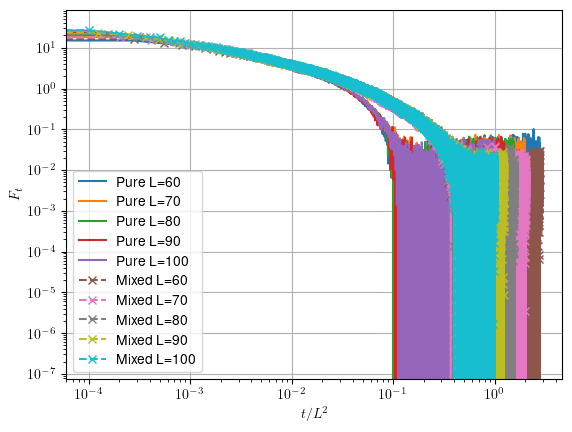

In [25]:
for l, purity in zip(ls[5:], pure_both_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity, '-', label=f"Pure L={l}")
for l, purity in zip(ls[5:], mixed_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity, 'x--', label=f"Mixed L={l}")
    
pyplot.xlabel('$t/L^2$')
pyplot.ylabel(r'$F_t$')
pyplot.yscale('log')
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.show()

for l, purity in zip(ls[5:], pure_both_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity - 1.0, '-', label=f"Pure L={l}")
for l, purity in zip(ls[5:], mixed_purities[5:]):
    T = len(purity)
    pyplot.plot(numpy.arange(T) / (l**2), purity - 0.5, 'x--', label=f"Mixed L={l}")
    
pyplot.xlabel('$t/L^2$')
pyplot.ylabel(r'$F_t$')
pyplot.yscale('log')
pyplot.xscale('log')
pyplot.legend()
pyplot.grid()
pyplot.show()

# Chunks of Dimers

We restrict to a single particle sector, the particle can be found in one of `num_mixed` sites. The purity of the state is set by how many of those pairs of sites form dimers.

In [34]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [128]:
def check_dimer_purities(L,num_mixed):
    purities = []
    true_purities = []
    
    states = numpy.arange(0,L, (L-1)//(num_mixed-1))
    
    # Go from all pure, to groups of 2, 4, etc
    
    dimer_states = []
    for dimer_size in 2**numpy.arange(0, 1+int(numpy.floor(numpy.log2(num_mixed)))):
        dimers_in_mixture = numpy.array(list(chunks(states, dimer_size)), dtype=numpy.uint64)
    
        dimers_in_mixture_states = []
        for dimer in dimers_in_mixture:
            if len(dimer.shape) == 1:
                dimer = numpy.expand_dims(dimer, axis=1)
        
            amplitudes = numpy.ones((dimer_size,),dtype=numpy.complex128)/numpy.sqrt(dimer_size)
            state = py_entropy.MultidefectPureState(dimer, amplitudes)
            dimers_in_mixture_states.append(state)
    
        mixed_state = [(1/len(dimers_in_mixture_states), state) for state in dimers_in_mixture_states] 
        state = py_entropy.MultiDefectState.new_mixed_from_states(states=mixed_state, 
                                                                  n_sites=L,
                                                                  num_experiments=32,
                                                                  skip_float_checks=False)
        purity = state.apply_alternative_layers_and_save_mean_purity(n_layers)
        purities.append(purity)
        true_purities.append(1/len(dimers_in_mixture_states))
    return numpy.array(purities), numpy.array(true_purities)

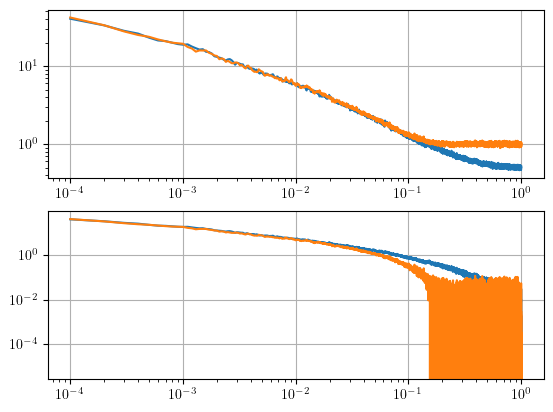

In [133]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 2)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, p - tp)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()

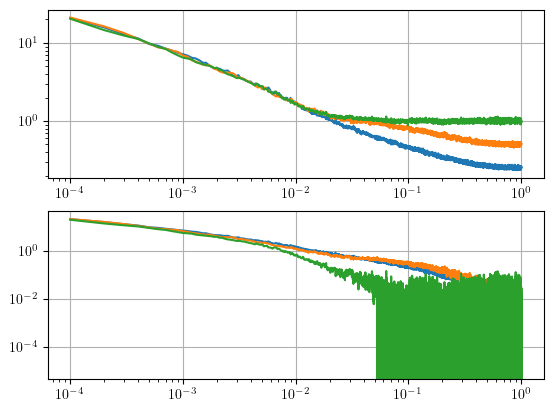

In [134]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 4)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, p - tp)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()

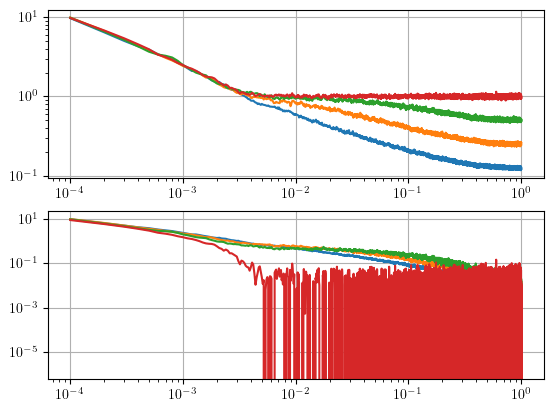

In [135]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 8)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, p - tp)
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()

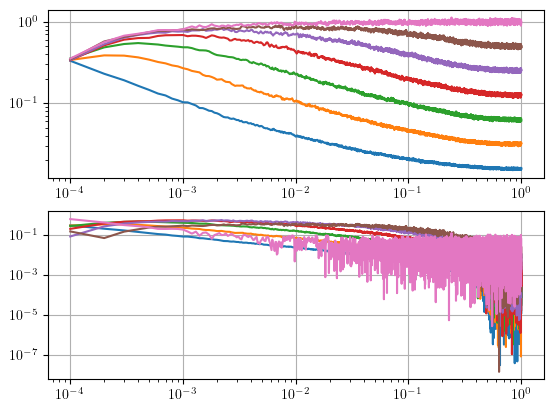

In [137]:
fig, axs = pyplot.subplots(2)

ps, tps = check_dimer_purities(128, 64)
for p, tp in zip(ps, tps):
    axs[0].plot(numpy.arange(1, len(p)+1)/L**2, p)
    axs[1].plot(numpy.arange(1, len(p)+1)/L**2, abs(p - tp))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[0].grid()
axs[1].grid()
pyplot.show()